### Bootstrap, Bagging, Случайный лес. Открытый курс машинного обучения ods.ai

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

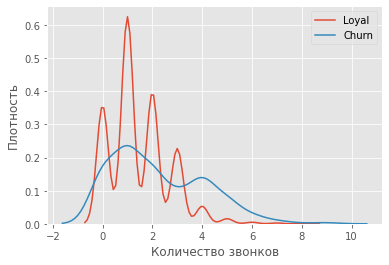

In [2]:
telecom_data = pd.read_csv('.../telecom_churn.csv')

fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == False]['Customer service calls'], label = 'Loyal')
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == True]['Customer service calls'], label = 'Churn')        
fig.set(xlabel='Количество звонков', ylabel='Плотность')    
plt.show()

#### Предобработка данных

In [9]:
telecom_data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [10]:
# функция для генерации подвыборок с помощью бутстрэпа
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
# функция для интервальной оценки
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
loyal_calls = telecom_data[telecom_data['Churn'] == False]['Customer service calls'].values
churn_calls= telecom_data[telecom_data['Churn'] == True]['Customer service calls'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
loyal_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(loyal_calls, 1000)]
churn_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(churn_calls, 1000)]

#  выводим интервальную оценку среднего
print("Service calls from loyal:  mean interval",  stat_intervals(loyal_mean_scores, 0.05))
print("Service calls from churn:  mean interval",  stat_intervals(churn_mean_scores, 0.05))

Service calls from loyal:  mean interval [1.4077193  1.49473684]
Service calls from churn:  mean interval [2.0621118  2.39761905]


Выберем только числовые признаки и обучим Случайный лес на 5-ти кратной кросс-валидации

In [12]:
cols = []
for i in telecom_data.columns:
    if (telecom_data[i].dtype == 'float64') or  (telecom_data[i].dtype == 'int64'):
        cols.append(i)

X, y = telecom_data[cols].copy(), np.asarray(telecom_data['Churn'], dtype = 'int8')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
rfc = RandomForestClassifier(n_jobs=-1, random_state=17, oob_score=True)
result = cross_val_score(rfc, X, y, cv=skf)

print('Точность модели без настройки гиперпараметров: ', result.mean() * 100)

Точность модели без настройки гиперпараметров:  92.2589606097852


Выбор оптимального количества деревьев

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
grid_trees = [1, 3, 5, 10, 15, 20, 30, 50, 60, 75, 76, 77, 78, 79, 100]

forest = RandomForestClassifier(n_jobs=-1, random_state=17)

for rtree in grid_trees:
    
    rfc = RandomForestClassifier(n_estimators=rtree, n_jobs=-1, random_state=17, oob_score=False)
    temp_train_acc = []
    temp_test_acc = []
    for index_train, index_test in skf.split(X, y):
        X_train, X_test = X.iloc[index_train], X.iloc[index_test]
        y_train, y_test =  y[index_train], y[index_test]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        grid_trees[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.26% with 77 trees


Text(0.5, 0, 'N_estimators')

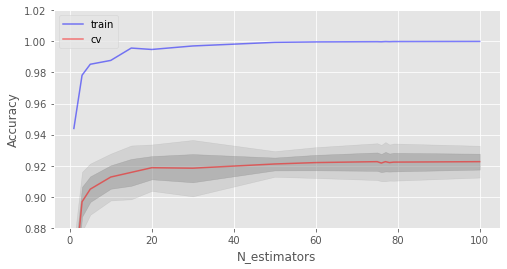

In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(grid_trees, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(grid_trees, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(grid_trees, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(grid_trees, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

Выбор оптимальной глубины деревьев

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

acc_train = []
acc_test = []
temp_acc_train = []
temp_acc_test = []
max_depth_trees = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24, 30, 50]

for depth_tree in max_depth_trees:
    
    rfc = RandomForestClassifier(n_estimators=77, max_depth=depth_tree, n_jobs=-1, random_state=17)
    temp_acc_train = []
    temp_acc_test = []
    
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_acc_train.append(rfc.score(X_train,  y_train))
        temp_acc_test.append(rfc.score(X_test,  y_test))
    
    acc_train.append(temp_acc_train)
    acc_test.append(temp_acc_test)
    
acc_train, acc_test = np.asarray(acc_train), np.asarray(acc_test)
print("Best accuracy on CV(max_depth) is {:.2f}% with {} trees".format(max(acc_test.mean(axis=1))*100, 
                                                        max_depth_trees[np.argmax(acc_test.mean(axis=1))]))

Best accuracy on CV(max_depth) is 92.62% with 15 trees


Text(0.5, 0, 'max_depth')

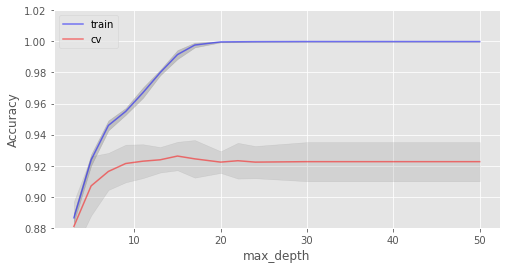

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_trees, acc_train.mean(axis=1), color='blue', alpha=0.5, label='train')
ax.plot(max_depth_trees, acc_test.mean(axis=1), color='red', alpha=0.5, label='cv')
ax.fill_between(max_depth_trees, acc_train.mean(axis=1) - acc_train.std(axis=1), acc_train.mean(axis=1) + acc_train.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_trees, acc_test.mean(axis=1) - 2*acc_test.std(axis=1), acc_test.mean(axis=1) + 2*acc_test.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("max_depth")


Выбор минимального количества выборок в вершине

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

acc_train = []
acc_test = []
temp_acc_train = []
temp_acc_test = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

for min_samples_leaf_tree in min_samples_leaf_grid:
    
    rfc = RandomForestClassifier(n_estimators=77, max_depth=15, min_samples_leaf=min_samples_leaf_tree,
                                                                             n_jobs=-1, random_state=17)
    temp_acc_train = []
    temp_acc_test = []
    
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_acc_train.append(rfc.score(X_train,  y_train))
        temp_acc_test.append(rfc.score(X_test,  y_test))
    
    acc_train.append(temp_acc_train)
    acc_test.append(temp_acc_test)
    
acc_train, acc_test = np.asarray(acc_train), np.asarray(acc_test)
print("Best accuracy on CV(min_samples_leaf) is {:.2f}% with {} samples".format(max(acc_test.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(acc_test.mean(axis=1))]))

Best accuracy on CV(min_samples_leaf) is 92.62% with 1 samples


Text(0.5, 0, 'min_samples_leaf')

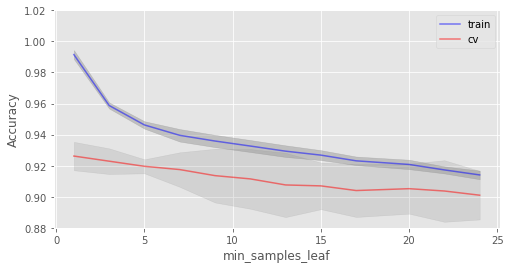

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, acc_train.mean(axis=1), color='blue', alpha=0.5, label='train')
ax.plot(min_samples_leaf_grid, acc_test.mean(axis=1), color='red', alpha=0.5, label='cv')
ax.fill_between(min_samples_leaf_grid, acc_train.mean(axis=1) - acc_train.std(axis=1), acc_train.mean(axis=1) + acc_train.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, acc_test.mean(axis=1) - 2*acc_test.std(axis=1), acc_test.mean(axis=1) + 2*acc_test.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("min_samples_leaf")

Выбор максимального количества признаков, которые следует учитывать при разделении

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

acc_train = []
acc_test = []
temp_acc_train = []
temp_acc_test = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

for max_features_tree in max_features_grid:
    
    rfc = RandomForestClassifier(n_estimators=77, max_depth=15, max_features=max_features_tree, min_samples_leaf=1,
                                                                             n_jobs=-1, random_state=17)
    temp_acc_train = []
    temp_acc_test = []
    
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_acc_train.append(rfc.score(X_train,  y_train))
        temp_acc_test.append(rfc.score(X_test,  y_test))
    
    acc_train.append(temp_acc_train)
    acc_test.append(temp_acc_test)
    
acc_train, acc_test = np.asarray(acc_train), np.asarray(acc_test)
print("Best accuracy on CV(max_features) is {:.2f}% with {} samples".format(max(acc_test.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(acc_test.mean(axis=1))]))

Best accuracy on CV(max_features) is 92.62% with 4 samples


Text(0.5, 0, 'max_features')

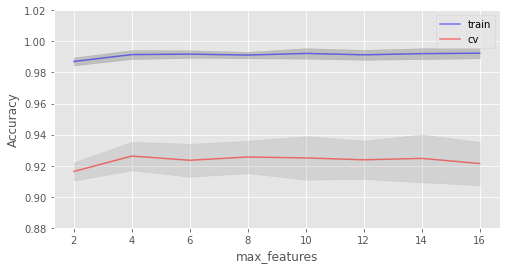

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, acc_train.mean(axis=1), color='blue', alpha=0.5, label='train')
ax.plot(max_features_grid, acc_test.mean(axis=1), color='red', alpha=0.5, label='cv')
ax.fill_between(max_features_grid, acc_train.mean(axis=1) - acc_train.std(axis=1), acc_train.mean(axis=1) + acc_train.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, acc_test.mean(axis=1) - 2*acc_test.std(axis=1), acc_test.mean(axis=1) + 2*acc_test.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("max_features")

Сделаем перебор всех возможных признаков и найдем наилучший набор

In [29]:
parameters = {'max_depth': [9, 11, 13, 15, 17], 'min_samples_leaf': [1, 3, 5, 7], 'max_features': [2, 4, 6, 8]}

rfc = RandomForestClassifier(n_estimators=77, n_jobs=-1, random_state=17)
gsc = GridSearchCV(rfc, parameters, cv=skf, n_jobs=-1, verbose=1)
gsc.fit(X, y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   55.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=77, n_jobs=-1,
                                              random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [9, 11, 13, 15, 17],
                         'max_features': [2, 4, 6, 8],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [30]:
print('Наилучший набор параметров: ', gsc.best_params_)


Наилучший набор параметров:  {'max_depth': 9, 'max_features': 8, 'min_samples_leaf': 3}


In [31]:
print('Точность предсказания модели: ', gsc.best_score_)

Точность предсказания модели:  0.9264917091004048
